## Analysis of the optimal inference parameters for the MicroCoderFIM model

This notebook  contains the code used to generate the results presented in the thesis regarding the optimal inference parameters for the MicroCoderFIM model.

Author: Matej Vadovic

Year: 2024

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

In [2]:
temp_records = json.load(open('temp-records.json'))
top_p_records = json.load(open('top-p-records.json'))

# Create directory for plot
if not os.path.exists('fig'):
    os.makedirs('fig')

In [3]:
data = []
for threshold, size_dict in temp_records.items():
    for size, score_dict in size_dict.items():
        for score_type, value in score_dict.items():
            data.append({
                'temperature': float(threshold),
                'Max Tokens': int(size),
                'Metric': score_type,
                'Value': value
            })

# Creating DataFrame
df_temp = pd.DataFrame(data)

# Rename metrics to human readable names
df_temp['Metric'] = df_temp['Metric'].replace({
    'chrf': 'ChrF++',
    'rouge': 'ROUGE-L',
    'codebleu': 'CodeBLEU',
    'bleu': 'BLEU'
})

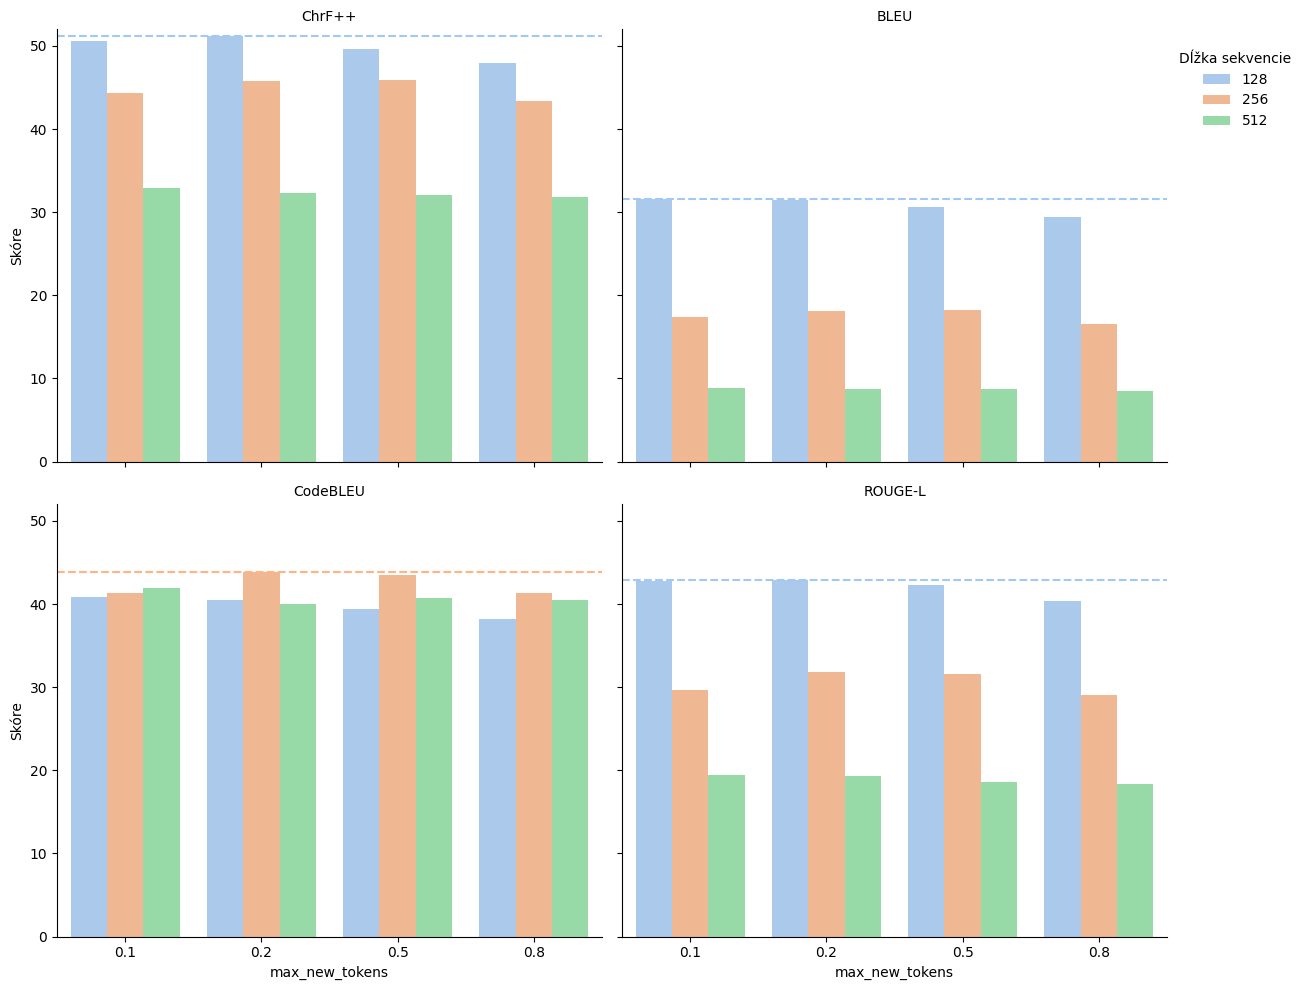

In [4]:
plot_2x2 = sns.catplot(
    data=df_temp, kind="bar",
    x="temperature", y="Value",
    hue="Max Tokens", col="Metric",
    palette="pastel", col_wrap=2,
    height=5, aspect=1.2
)

# Setting plot titles and labels
plot_2x2.set_titles("{col_name}")
plot_2x2.set_axis_labels("max_new_tokens", "Skóre")
plot_2x2.set(ylim=(0, 52))
plot_2x2._legend.set_title("Dĺžka sekvencie")
# Set legend labels
plot_2x2._legend.set_bbox_to_anchor([1.01, 0.9])


palette = sns.color_palette("pastel", len(df_temp["Max Tokens"].unique()))

# Create a dictionary mapping temperatures to colors
color_dict = dict(zip(df_temp["Max Tokens"].unique(), palette))

# Add horizontal line to highlight the best value
for ax, (score_type, sub_df) in zip(plot_2x2.axes.flat, df_temp.groupby("Metric", sort=False)):
    # Find the temperature with the highest value for this Metric
    best_temp = sub_df.loc[sub_df['Value'].idxmax(), "Max Tokens"]
    # Get the color corresponding to this temperature
    best_color = color_dict[best_temp]
    # Draw the horizontal line with this color
    ax.axhline(y=max(sub_df['Value']), color=best_color, linestyle='--')

# Adjust layout to fit everything nicely
plot_2x2.tight_layout()

# Show the plot
plt.show()

# Save in svg format
plot_2x2.savefig('fig/temp_test.svg')


In [5]:
data = []
for threshold, size_dict in top_p_records.items():
    for size, score_dict in size_dict.items():
        for score_type, value in score_dict.items():
            data.append({
                'top_p': float(threshold),
                'Max Tokens': int(size),
                'Metric': score_type,
                'Value': value
            })

# Creating DataFrame
df_top_p = pd.DataFrame(data)

# Rename metrics to human readable names
df_top_p['Metric'] = df_top_p['Metric'].replace({
    'chrf': 'ChrF++',
    'rouge': 'ROUGE-L',
    'codebleu': 'CodeBLEU',
    'bleu': 'BLEU'
})

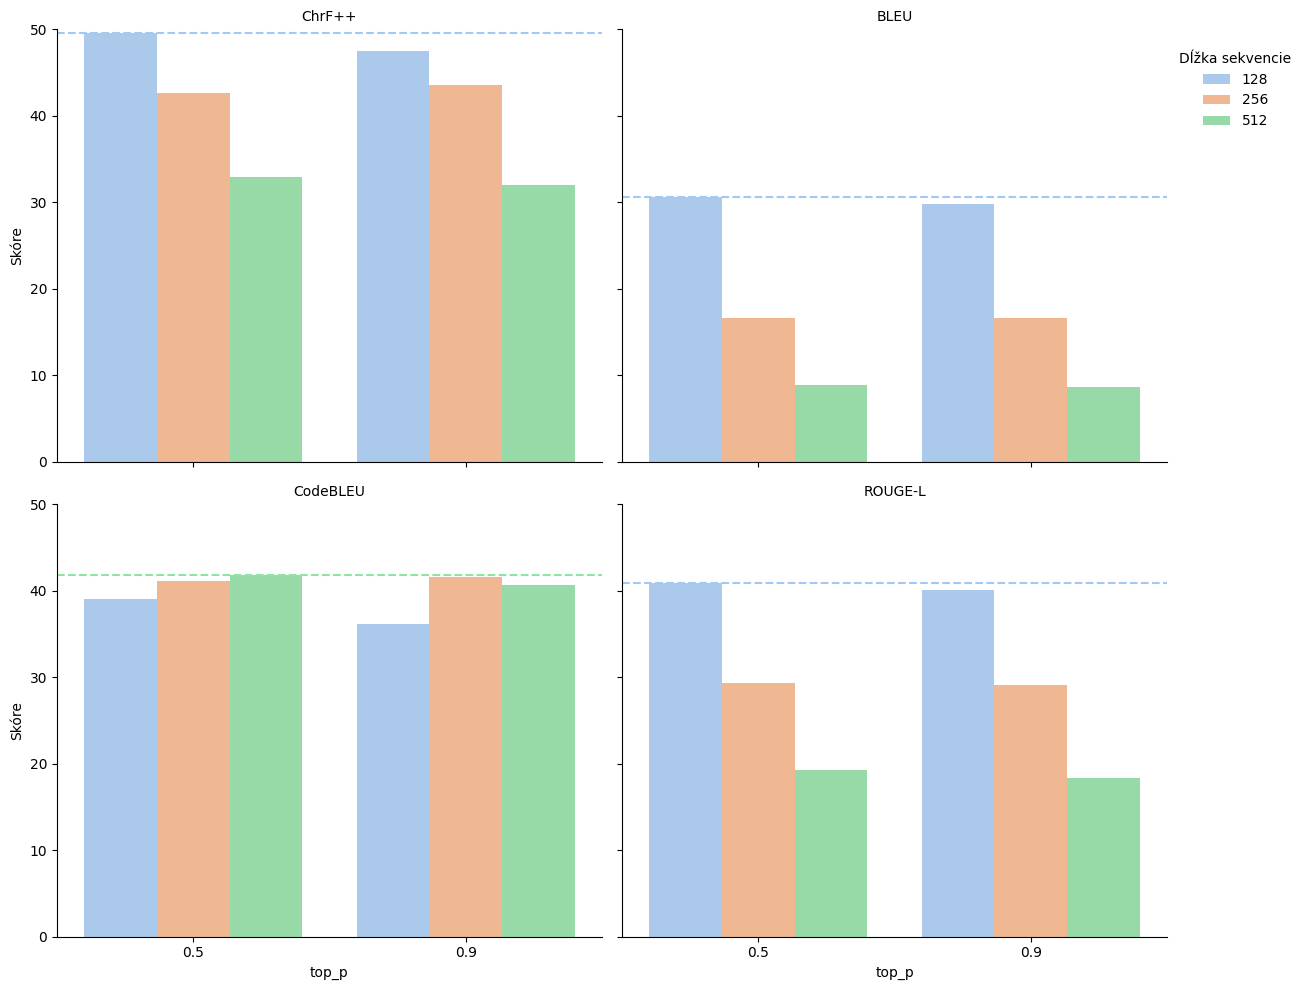

In [6]:
plot_2x1 = sns.catplot(
    data=df_top_p, kind="bar",
    x="top_p", y="Value",
    hue="Max Tokens", col="Metric",
    palette="pastel", col_wrap=2,
    height=5, aspect=1.2
)

# Setting plot titles and labels
plot_2x1.set_titles("{col_name}")
plot_2x1.set_axis_labels("top_p", "Skóre")
plot_2x1.set(ylim=(0, 50))
# Set legend title
plot_2x1._legend.set_title("Dĺžka sekvencie")
# Set legend labels
plot_2x1._legend.set_bbox_to_anchor([1.01, 0.9])


# Create a color palette
palette = sns.color_palette("pastel", len(df_top_p['Max Tokens'].unique()))

# Create a dictionary mapping 'Max Tokens' to colors
color_dict = dict(zip(df_top_p['Max Tokens'].unique(), palette))

# Add horizontal line to highlight the best value
for ax, (score_type, sub_df) in zip(plot_2x1.axes.flat, df_top_p.groupby("Metric", sort=False)):
    # Find the 'Max Tokens' with the highest value for this Metric
    best_max_tokens = sub_df.loc[sub_df['Value'].idxmax(), 'Max Tokens']
    # Get the color corresponding to this 'Max Tokens'
    best_color = color_dict[best_max_tokens]
    # Draw the horizontal line with this color
    ax.axhline(y=max(sub_df['Value']), color=best_color, linestyle='--')

# Adjust layout to fit everything nicely
plot_2x1.tight_layout()


# Show the plot
plt.show()

# Save in svg format
plot_2x1.savefig('fig/top_p_test.svg')

In [7]:
# Calculate percentage improvement in performance with respect to the max_tokens
tab1 = df_temp.groupby(['temperature', 'Max Tokens', 'Metric']).mean().unstack('Max Tokens').pct_change(axis=1)*100

# Reset the index to make 'Metric' a column again
tab1 = tab1.iloc[:, 1:].groupby('Metric').mean().stack().reset_index()

# Calculate percentage improvement in performance with respect to the max_tokens
tab2 = df_top_p.groupby(['top_p', 'Max Tokens', 'Metric']).mean().unstack('Max Tokens').pct_change(axis=1)*100
# Reset the index to make 'Metric' a column again
tab2 = tab2.iloc[:, 1:].groupby('Metric').mean().stack().reset_index()

tab = pd.concat([tab1, tab2], ignore_index=True)

/tmp/ipykernel_110902/2225928549.py:5: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  tab1 = tab1.iloc[:, 1:].groupby('Metric').mean().stack().reset_index()
/tmp/ipykernel_110902/2225928549.py:10: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  tab2 = tab2.iloc[:, 1:].groupby('Metric').mean().stack().reset_index()


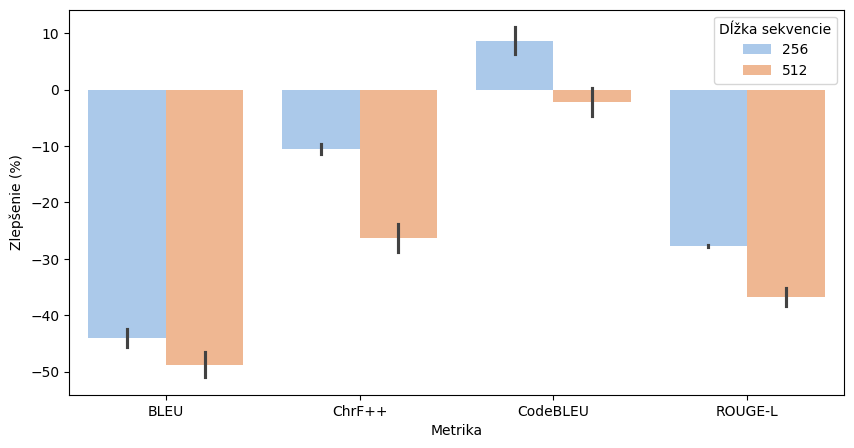

In [8]:
# Create the barplot
plt.figure(figsize=(10, 5))
# Create plto with error bars
plot = sns.barplot(data=tab, x='Metric', y='Value', hue='Max Tokens', palette='pastel', errorbar='sd')
# Set the y-axis label
plot.set_ylabel('Zlepšenie (%)')
# Set the x-axis label
plot.set_xlabel('Metrika')
# Set the legend title
plot.legend(title='Dĺžka sekvencie')
# Set the y-axis limits
# Show the plot
plt.show()

# Save in svg format
plot.figure.savefig('fig/improvement.svg')